In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_excel("train__1_.xlsx")
df_train.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners
0,2826,793,2005-04-02,410,908,2.0,0.0,15,1
1,2827,793,2005-04-02,338,597,3.0,2.0,3,6
2,2828,793,2005-04-02,1364,246,2.0,3.0,13,2
3,2829,793,2005-04-02,1088,1397,1.0,0.0,2,5
4,2830,793,2005-04-02,830,1412,2.0,3.0,3,6


looks like the data is ordered by matchid and the date, lets just make sure.

In [3]:
df_train = df_train.sort_values(['MatchId', 'Date'])

lets get the shape

In [4]:
df_train.shape

(23830, 9)

lets check for any missing values

In [5]:
df_train.isna().sum()

MatchId         0
LeagueId        0
Date            0
HomeTeamId      0
AwayTeamId      0
Home_Goals      8
Away_Goals      8
Home_Corners    0
Away_Corners    0
dtype: int64

So there are some games where the home and away goals are nan, worth noting. As we are asked to predict the total corners in a game, lets just create columns of total goals and total corners.

In [6]:
df_train['Total_Corners'] = df_train['Away_Corners'] + df_train['Home_Corners']
df_train['Total_Goals'] = df_train['Away_Goals'] + df_train['Home_Goals']

In [7]:
df_train

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,Total_Goals
0,2826,793,2005-04-02,410,908,2.0,0.0,15,1,16,2.0
1,2827,793,2005-04-02,338,597,3.0,2.0,3,6,9,5.0
2,2828,793,2005-04-02,1364,246,2.0,3.0,13,2,15,5.0
3,2829,793,2005-04-02,1088,1397,1.0,0.0,2,5,7,1.0
4,2830,793,2005-04-02,830,1412,2.0,3.0,3,6,9,5.0
...,...,...,...,...,...,...,...,...,...,...,...
23826,307624,800,2010-12-18,944,8291,2.0,1.0,3,4,7,3.0
23827,307625,800,2010-12-18,4704,4705,4.0,0.0,4,4,8,4.0
23828,307626,800,2010-12-18,2113,250,1.0,1.0,5,5,10,2.0
23669,307965,781,2010-11-24,613,541,1.0,3.0,5,5,10,4.0


I just wanted to see if there is a correlation between the total corners and total goals

In [8]:
df_train[['Total_Corners', 'Total_Goals']].corr()

,Total_Corners,Total_Goals
Total_Corners,1.000000,-0.006132
Total_Goals,-0.006132,1.000000


In [9]:
df_train['Win'] = (df_train['Home_Goals'] > df_train['Away_Goals']).astype(int)
df_train['Draw'] = (df_train['Home_Goals'] == df_train['Away_Goals']).astype(int)
df_train['Loss'] = (df_train['Home_Goals'] < df_train['Away_Goals']).astype(int)

In [10]:
df_train[['Total_Corners', 'Total_Goals', 'Win']].corr()

,Total_Corners,Total_Goals,Win
Total_Corners,1.000000,-0.006132,-0.024621
Total_Goals,-0.006132,1.000000,0.164180
Win,-0.024621,0.164180,1.000000


Let us try to see how many games are won and how many games were lost and how many games were drawn across each league

In [11]:
summary_wins_by_league = df_train.groupby('LeagueId').agg(
    {
        'Win':'sum',
        'Loss':'sum',
        'Draw':'sum'
    }
)

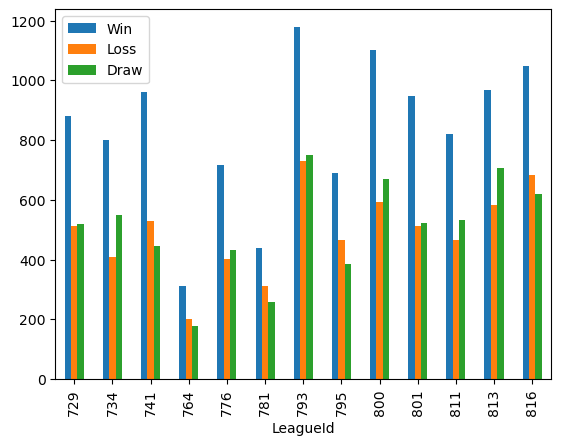

In [12]:
summary_wins_by_league.plot.bar()
plt.show()

Lets see how the goals and corners change by league

In [13]:
summary_gc_by_league = df_train.groupby('LeagueId').agg(
    {
        'Total_Corners':'sum',
        'Total_Goals':'sum',
    }
)

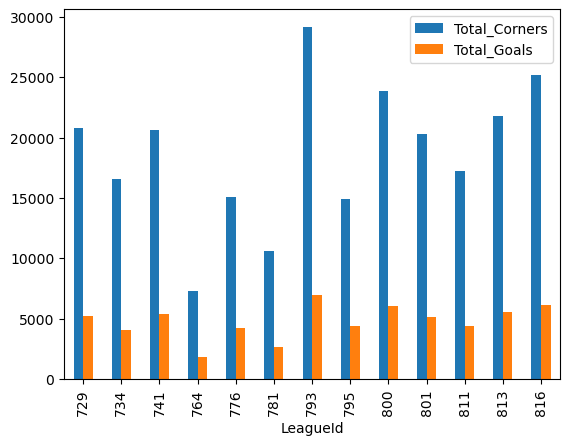

In [14]:
summary_gc_by_league.plot.bar()
plt.show()

Lets see the distribution of corners and goals by home and away teams specific to each league

In [15]:
summary_goals_by_league = df_train.groupby('LeagueId').agg(
    {
        'Home_Goals':'sum',
        'Away_Goals':'sum',
    }
)

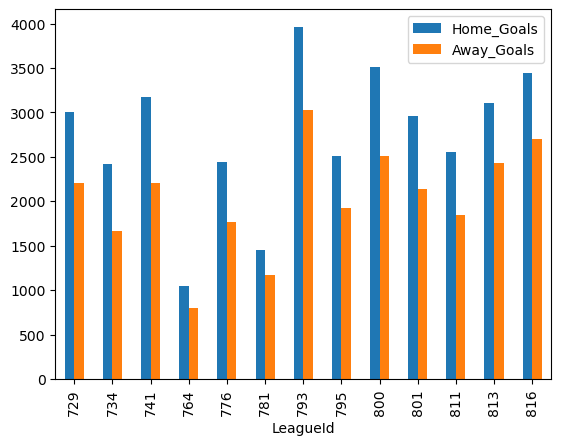

In [16]:
summary_goals_by_league.plot.bar()
plt.show()

In [17]:
summary_corners_by_league = df_train.groupby('LeagueId').agg(
    {
        'Home_Corners':'sum',
        'Away_Corners':'sum',
    }
)

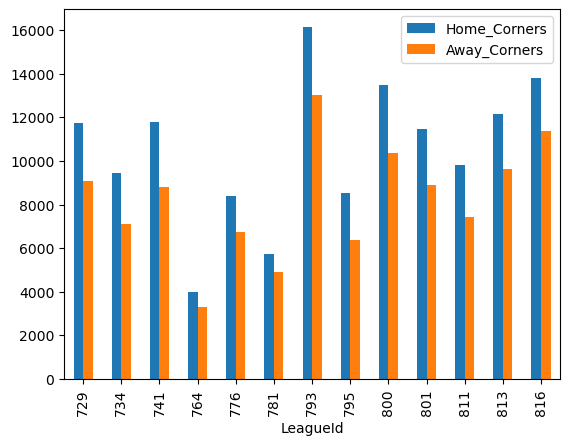

In [18]:
summary_corners_by_league.plot.bar()
plt.show()

A clear home advantage. As we are predicting the total corners, lets see how its actually distributed, total corners in a game is an integer, it suggests a Poisson distribution. Lets look at the statistics and see.

In [19]:
df_train['Total_Corners'].describe()

count    23830.000000
mean        10.219471
std          3.451955
min          0.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         25.000000
Name: Total_Corners, dtype: float64

In [20]:
df_train['Total_Corners'].std()**2/df_train['Total_Corners'].mean()

1.1660086286264943

Slightly overdispersed the ratio is 1.16 and so we can still get away with using a Poisson distribution but I guess if we would like to capture longer tail we might want to use a Negative Binomial distribution

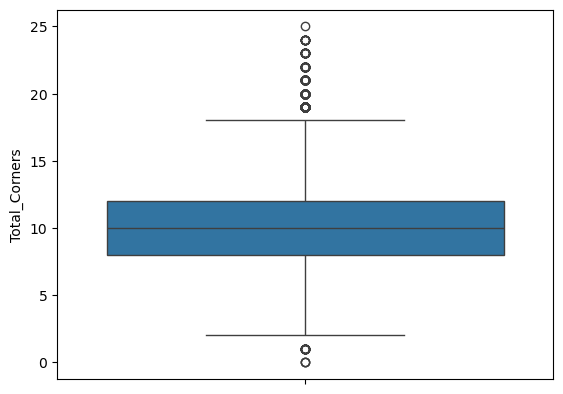

In [21]:
sns.boxplot(df_train['Total_Corners'])
plt.show()

I want to see how the games are played and will plot the dates

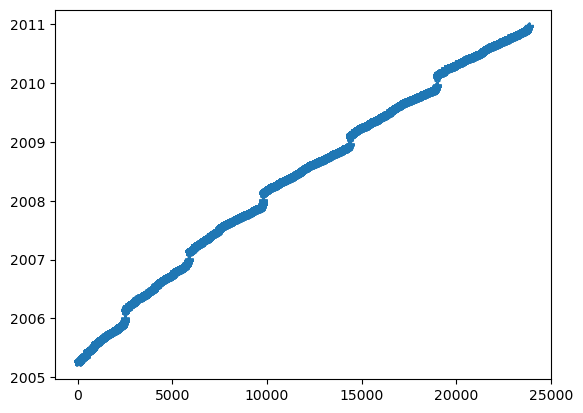

In [22]:
plt.plot(df_train["Date"],'*')
plt.show()

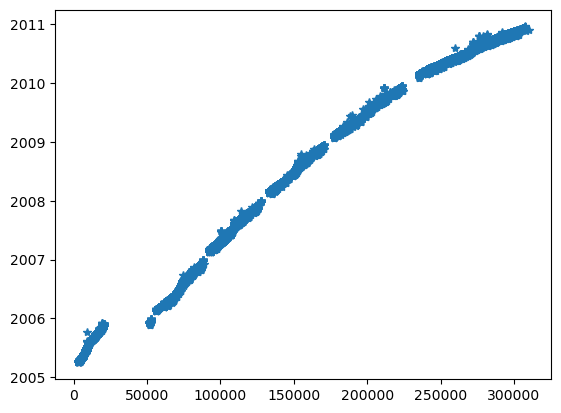

In [23]:
plt.plot(df_train["MatchId"], df_train["Date"],'*')
plt.show()

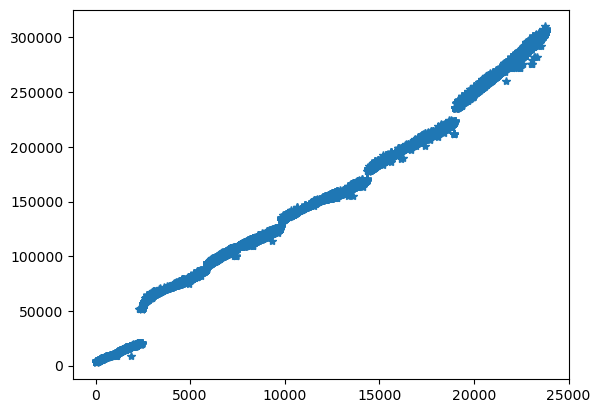

In [24]:
plt.plot(df_train["MatchId"],'*')
plt.show()

There seems to be clear separation between seasons, I wonder if we can get the season boundaries

So I guess these season boundaries are league specific and one needs to take that into account.

In [25]:
df_train = df_train.sort_values(
    ['LeagueId', 'Date', 'MatchId'],
    kind='mergesort' 
).reset_index(drop=True)

In [26]:
df_train['Day_Diff'] = df_train.groupby('LeagueId')['Date'].diff().dt.days

df_train['Day_Diff'].describe()

count    23817.000000
mean         1.124575
std          5.281834
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        120.000000
Name: Day_Diff, dtype: float64

Now we see that the separation is 120 days. Lets see what to do about it. May be lets assign season ids. Lets have a gap threshold of say 60 days

In [27]:
gap = 60.0
df_train['new_season'] = df_train['Day_Diff'].gt(gap).fillna(False)

df_train['new_season']

0        False
1        False
2        False
3        False
4        False
         ...  
23825    False
23826    False
23827    False
23828    False
23829    False
Name: new_season, Length: 23830, dtype: bool

In [28]:
df_train['SeasonId'] = df_train.groupby(['LeagueId'])['new_season'].cumsum()
df_train['SeasonId']

0        0
1        0
2        0
3        0
4        0
        ..
23825    5
23826    5
23827    5
23828    5
23829    5
Name: SeasonId, Length: 23830, dtype: int64

In [29]:
df_train['SeasonId'].max()

5

So there are 6 seasons I see

In [30]:
df_train

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,Total_Goals,Win,Draw,Loss,Day_Diff,new_season,SeasonId
0,3784,729,2005-04-02,1740,396,0.0,0.0,8,2,10,0.0,0,1,0,NaN,False,0
1,3785,729,2005-04-02,974,1193,2.0,2.0,6,2,8,4.0,0,1,0,0.0,False,0
2,3786,729,2005-04-02,1118,1237,5.0,0.0,4,4,8,5.0,1,0,0,0.0,False,0
3,3787,729,2005-04-02,912,445,3.0,3.0,5,2,7,6.0,0,1,0,0.0,False,0
4,3790,729,2005-04-03,1741,297,2.0,0.0,6,2,8,2.0,1,0,0,1.0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23825,296374,816,2010-11-06,654,486,3.0,2.0,6,3,9,5.0,1,0,0,0.0,False,5
23826,296375,816,2010-11-06,419,197,1.0,1.0,5,3,8,2.0,0,1,0,0.0,False,5
23827,296376,816,2010-11-06,448,312,3.0,2.0,4,5,9,5.0,1,0,0,0.0,False,5
23828,296377,816,2010-11-06,1016,998,0.0,0.0,5,4,9,0.0,0,1,0,0.0,False,5


Lets think about what features we might need for predicting the total corners for the games in the test set.

I would personally like to have a recent performance (last 5 games) home team goals scored and corners scored average at home and away team goals scored and corners scored average while they were away. I believe teams that have a good recent performance would have a good confidence and might have higher possession in the coming games. We will reset this after every season

I then would like to create a cumulative average of home team goals scored and conceded along with away team goals scored and conceded and the same for the corners. We will reset this after every season.

I will also create a score of the home team and away team. We will reset this after every season.

In [31]:
df_train['Home_Goals_Conceded'] = df_train['Away_Goals']
df_train['Home_Corners_Conceded'] = df_train['Away_Corners']
df_train['Away_Goals_Conceded'] = df_train['Home_Goals']
df_train['Away_Corners_Conceded'] = df_train['Home_Corners']

In [32]:
df_train

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,...,Win,Draw,Loss,Day_Diff,new_season,SeasonId,Home_Goals_Conceded,Home_Corners_Conceded,Away_Goals_Conceded,Away_Corners_Conceded
0,3784,729,2005-04-02,1740,396,0.0,0.0,8,2,10,...,0,1,0,NaN,False,0,0.0,2,0.0,8
1,3785,729,2005-04-02,974,1193,2.0,2.0,6,2,8,...,0,1,0,0.0,False,0,2.0,2,2.0,6
2,3786,729,2005-04-02,1118,1237,5.0,0.0,4,4,8,...,1,0,0,0.0,False,0,0.0,4,5.0,4
3,3787,729,2005-04-02,912,445,3.0,3.0,5,2,7,...,0,1,0,0.0,False,0,3.0,2,3.0,5
4,3790,729,2005-04-03,1741,297,2.0,0.0,6,2,8,...,1,0,0,1.0,False,0,0.0,2,2.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23825,296374,816,2010-11-06,654,486,3.0,2.0,6,3,9,...,1,0,0,0.0,False,5,2.0,3,3.0,6
23826,296375,816,2010-11-06,419,197,1.0,1.0,5,3,8,...,0,1,0,0.0,False,5,1.0,3,1.0,5
23827,296376,816,2010-11-06,448,312,3.0,2.0,4,5,9,...,1,0,0,0.0,False,5,2.0,5,3.0,4
23828,296377,816,2010-11-06,1016,998,0.0,0.0,5,4,9,...,0,1,0,0.0,False,5,0.0,4,0.0,5


Let us first calculate cumulative averages for each team across each league 

In [33]:
def expanding_means(df, keys, value_col, out_col):
    df = df.sort_values(keys + ['Date', 'MatchId'], kind='mergesort').copy()
    #df[out_col] = df.groupby(keys, sort=False)[value_col].expanding().mean().shift(1).reset_index(level=list(range(len(keys))), drop=True)
    #rolled = (
    #    df.groupby(keys, sort=False)[value_col]
    #      .apply(lambda s: s.shift(1).expanding().mean())   # shift avoids look-ahead
    #)
    #df[out_col] = rolled
    g = df.groupby(keys, sort=False)
    cnt = g.cumcount()
    csum = g[value_col].cumsum()
    df[out_col] = np.where(cnt > 0, (csum - df[value_col]) / cnt, np.nan)
    return df

In [34]:
df_train = expanding_means(df_train, ['LeagueId','SeasonId','HomeTeamId'], 'Home_Corners', 'HomeTeam_CumHomeCornersAvg')
df_train = expanding_means(df_train, ['LeagueId','SeasonId','HomeTeamId'], 'Away_Corners', 'HomeTeam_CumAwayCornersAvg')
df_train = expanding_means(df_train, ['LeagueId','SeasonId','AwayTeamId'], 'Away_Corners', 'AwayTeam_CumAwayCornersAvg')
df_train = expanding_means(df_train, ['LeagueId','SeasonId','AwayTeamId'], 'Home_Corners', 'AwayTeam_CumHomeCornersAvg')

In [35]:
df_train.sort_values(['LeagueId','SeasonId','Date','MatchId']).head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,...,new_season,SeasonId,Home_Goals_Conceded,Home_Corners_Conceded,Away_Goals_Conceded,Away_Corners_Conceded,HomeTeam_CumHomeCornersAvg,HomeTeam_CumAwayCornersAvg,AwayTeam_CumAwayCornersAvg,AwayTeam_CumHomeCornersAvg
0,3784,729,2005-04-02,1740,396,0.0,0.0,8,2,10,...,False,0,0.0,2,0.0,8,NaN,NaN,NaN,NaN
1,3785,729,2005-04-02,974,1193,2.0,2.0,6,2,8,...,False,0,2.0,2,2.0,6,NaN,NaN,NaN,NaN
2,3786,729,2005-04-02,1118,1237,5.0,0.0,4,4,8,...,False,0,0.0,4,5.0,4,NaN,NaN,NaN,NaN
3,3787,729,2005-04-02,912,445,3.0,3.0,5,2,7,...,False,0,3.0,2,3.0,5,NaN,NaN,NaN,NaN
4,3790,729,2005-04-03,1741,297,2.0,0.0,6,2,8,...,False,0,0.0,2,2.0,6,NaN,NaN,NaN,NaN


Now recent performances

In [36]:
def rolling_means(df,keys, value_col, out_col):
    df = df.sort_values(keys + ['Date', 'MatchId'], kind='mergesort').copy()
    #rolled = (df.groupby(keys, sort=False)[value_col].rolling(window = 5, min_periods = 1).mean())#.shift(1)#.reset_index(level=list(range(len(keys))), drop=True)
    #df[out_col] = rolled.reindex(df.index).values
    res = (df.groupby(keys, sort=False)[value_col]
             .apply(lambda s: s.shift(1).rolling(window = 5, min_periods=1).mean()))
    df[out_col] = res.to_numpy()
    return df

In [37]:
df_train = rolling_means(df_train, ['LeagueId','SeasonId','HomeTeamId'], 'Home_Corners', 'HomeTeam_rollHomeCornersAvg')
df_train = rolling_means(df_train, ['LeagueId','SeasonId','HomeTeamId'], 'Away_Corners', 'HomeTeam_rollAwayCornersAvg')
df_train = rolling_means(df_train, ['LeagueId','SeasonId','AwayTeamId'], 'Away_Corners', 'AwayTeam_rollAwayCornersAvg')
df_train = rolling_means(df_train, ['LeagueId','SeasonId','AwayTeamId'], 'Home_Corners', 'AwayTeam_rollHomeCornersAvg')

In [38]:
df_train.sort_values(['LeagueId','SeasonId','Date','MatchId'])

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,...,Away_Goals_Conceded,Away_Corners_Conceded,HomeTeam_CumHomeCornersAvg,HomeTeam_CumAwayCornersAvg,AwayTeam_CumAwayCornersAvg,AwayTeam_CumHomeCornersAvg,HomeTeam_rollHomeCornersAvg,HomeTeam_rollAwayCornersAvg,AwayTeam_rollAwayCornersAvg,AwayTeam_rollHomeCornersAvg
0,3784,729,2005-04-02,1740,396,0.0,0.0,8,2,10,...,0.0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3785,729,2005-04-02,974,1193,2.0,2.0,6,2,8,...,2.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3786,729,2005-04-02,1118,1237,5.0,0.0,4,4,8,...,5.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3787,729,2005-04-02,912,445,3.0,3.0,5,2,7,...,3.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3790,729,2005-04-03,1741,297,2.0,0.0,6,2,8,...,2.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23825,296374,816,2010-11-06,654,486,3.0,2.0,6,3,9,...,3.0,6,6.590909,4.727273,4.142857,6.333333,7.0,2.8,4.8,4.2
23826,296375,816,2010-11-06,419,197,1.0,1.0,5,3,8,...,1.0,5,5.809524,4.666667,4.727273,5.636364,6.8,4.4,4.0,6.0
23827,296376,816,2010-11-06,448,312,3.0,2.0,4,5,9,...,3.0,4,4.421053,6.000000,4.095238,6.809524,5.0,6.4,2.8,6.4
23828,296377,816,2010-11-06,1016,998,0.0,0.0,5,4,9,...,0.0,5,6.090909,5.090909,5.136364,5.636364,6.0,5.0,3.4,4.0


Now lets create a head2head average. Here we just have home team's home and away team's away

In [39]:
def h2h_expanding(df, value_col, out_col):
    group_cols = ['LeagueId', 'SeasonId', 'HomeTeamId', 'AwayTeamId']
    df = df.sort_values(group_cols + ['Date', 'MatchId'], kind='mergesort').copy()
    #df[out_col] = (
    #    df.groupby(group_cols, sort=False)[value_col]
    #      .expanding()
    #      .mean()
    #      .shift(1)
    #      .reset_index(level=list(range(len(group_cols))), drop=True)
    #)
    g = df.groupby(group_cols, sort=False)
    cnt = g.cumcount()
    csum = g[value_col].cumsum()
    df[out_col] = np.where(cnt > 0, (csum - df[value_col]) / cnt, np.nan)
    return df

df_train = h2h_expanding(df_train, 'Home_Corners', 'h2hHome_CornersAvg')
df_train = h2h_expanding(df_train, 'Away_Corners', 'h2hAway_CornersAvg')
df_train = h2h_expanding(df_train, 'Home_Goals', 'h2hHome_GoalsAvg')
df_train = h2h_expanding(df_train, 'Away_Goals', 'h2hAway_GoalsAvg')

In [40]:
df_train = df_train.sort_values(['LeagueId','SeasonId', 'Date', 'MatchId'], kind='mergesort')
df_train.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,...,AwayTeam_CumAwayCornersAvg,AwayTeam_CumHomeCornersAvg,HomeTeam_rollHomeCornersAvg,HomeTeam_rollAwayCornersAvg,AwayTeam_rollAwayCornersAvg,AwayTeam_rollHomeCornersAvg,h2hHome_CornersAvg,h2hAway_CornersAvg,h2hHome_GoalsAvg,h2hAway_GoalsAvg
0,3784,729,2005-04-02,1740,396,0.0,0.0,8,2,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3785,729,2005-04-02,974,1193,2.0,2.0,6,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3786,729,2005-04-02,1118,1237,5.0,0.0,4,4,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3787,729,2005-04-02,912,445,3.0,3.0,5,2,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3790,729,2005-04-03,1741,297,2.0,0.0,6,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets have a score for teams cumulative for each season

In [41]:
df_train.groupby(['LeagueId', 'SeasonId', 'HomeTeamId'])['Win'].cumcount()

0         0
1         0
2         0
3         0
4         0
         ..
23825    22
23826    21
23827    19
23828    22
23829    22
Length: 23830, dtype: int64

Now I believe we can calculate win, draw and loss rates h2h

In [42]:
df_train = h2h_expanding(df_train, 'Win', 'h2hHome_winrate')
df_train = h2h_expanding(df_train, 'Draw', 'h2hHome_drawrate')
df_train = h2h_expanding(df_train, 'Loss', 'h2hHome_lossrate')

In [43]:
df_train = df_train.sort_values(['LeagueId','SeasonId', 'Date', 'MatchId'], kind='mergesort')
df_train.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,...,HomeTeam_rollAwayCornersAvg,AwayTeam_rollAwayCornersAvg,AwayTeam_rollHomeCornersAvg,h2hHome_CornersAvg,h2hAway_CornersAvg,h2hHome_GoalsAvg,h2hAway_GoalsAvg,h2hHome_winrate,h2hHome_drawrate,h2hHome_lossrate
0,3784,729,2005-04-02,1740,396,0.0,0.0,8,2,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3785,729,2005-04-02,974,1193,2.0,2.0,6,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3786,729,2005-04-02,1118,1237,5.0,0.0,4,4,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3787,729,2005-04-02,912,445,3.0,3.0,5,2,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3790,729,2005-04-03,1741,297,2.0,0.0,6,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let us now get cumulative points of a team after each game.


In [44]:
def cumulative_points(df, team_col, win_col, draw_col, out_col):
    df = df.sort_values(['LeagueId','SeasonId', team_col, 'Date','MatchId'], kind='mergesort').copy()
    df['Points'] = 3*df[win_col] + 1*df[draw_col]  # 0 for loss
    g = df.groupby(['LeagueId','SeasonId', team_col], sort=False)

    cnt  = g.cumcount()
    csum = g['Points'].cumsum()

    df[out_col] = np.where(cnt > 0, (csum - df['Points']) / cnt, np.nan)
    return df.drop(columns='Points')

In [45]:
df_train = cumulative_points(df_train, 'HomeTeamId', 'Win', 'Draw', 'HomeTeam_CumPoints')
df_train = cumulative_points(df_train, 'AwayTeamId', 'Loss', 'Draw', 'AwayTeam_CumPoints')

In [46]:
df_train = df_train.sort_values(['LeagueId','SeasonId', 'Date', 'MatchId'], kind='mergesort')
df_train.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,...,AwayTeam_rollHomeCornersAvg,h2hHome_CornersAvg,h2hAway_CornersAvg,h2hHome_GoalsAvg,h2hAway_GoalsAvg,h2hHome_winrate,h2hHome_drawrate,h2hHome_lossrate,HomeTeam_CumPoints,AwayTeam_CumPoints
0,3784,729,2005-04-02,1740,396,0.0,0.0,8,2,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3785,729,2005-04-02,974,1193,2.0,2.0,6,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3786,729,2005-04-02,1118,1237,5.0,0.0,4,4,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3787,729,2005-04-02,912,445,3.0,3.0,5,2,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3790,729,2005-04-03,1741,297,2.0,0.0,6,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now recent performances as well

In [47]:
def rolling_rate(df, team_col, result_col, out_col, window=5):
    df = df.sort_values(['LeagueId','SeasonId', team_col, 'Date','MatchId'], kind='mergesort').copy()
    res = (
        df.groupby(['LeagueId','SeasonId', team_col], sort=False)[result_col]
          .apply(lambda s: s.shift(1).rolling(window, min_periods=1).mean())
    )
    df[out_col] = res.to_numpy()
    return df

In [48]:
# Home recent performance
df_train = rolling_rate(df_train, 'HomeTeamId', 'Win',  'HomeTeam_RecentWinRate',  window=5)
df_train = rolling_rate(df_train, 'HomeTeamId', 'Draw', 'HomeTeam_RecentDrawRate', window=5)
df_train = rolling_rate(df_train, 'HomeTeamId', 'Loss', 'HomeTeam_RecentLossRate', window=5)

# Away recent performance
df_train = rolling_rate(df_train, 'AwayTeamId', 'Loss',  'AwayTeam_RecentWinRate',  window=5)
df_train = rolling_rate(df_train, 'AwayTeamId', 'Draw', 'AwayTeam_RecentDrawRate', window=5)
df_train = rolling_rate(df_train, 'AwayTeamId', 'Win', 'AwayTeam_RecentLossRate', window=5)

In [49]:
df_train = df_train.sort_values(['LeagueId','SeasonId', 'Date', 'MatchId'], kind='mergesort')
df_train.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,...,h2hHome_drawrate,h2hHome_lossrate,HomeTeam_CumPoints,AwayTeam_CumPoints,HomeTeam_RecentWinRate,HomeTeam_RecentDrawRate,HomeTeam_RecentLossRate,AwayTeam_RecentWinRate,AwayTeam_RecentDrawRate,AwayTeam_RecentLossRate
0,3784,729,2005-04-02,1740,396,0.0,0.0,8,2,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3785,729,2005-04-02,974,1193,2.0,2.0,6,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3786,729,2005-04-02,1118,1237,5.0,0.0,4,4,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3787,729,2005-04-02,912,445,3.0,3.0,5,2,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3790,729,2005-04-03,1741,297,2.0,0.0,6,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let us now create league specific features

In [50]:
df_train = expanding_means(df_train, ['LeagueId','SeasonId'], 'Home_Corners', 'League_CumHomeCornersAvg')
df_train = expanding_means(df_train, ['LeagueId','SeasonId'], 'Away_Corners', 'League_CumAwayCornersAvg')
df_train = expanding_means(df_train, ['LeagueId','SeasonId'], 'Away_Goals', 'League_CumAwayGoalsAvg')
df_train = expanding_means(df_train, ['LeagueId','SeasonId'], 'Home_Goals', 'League_CumHomeGoalsAvg')

In [51]:
df_train

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,...,HomeTeam_RecentWinRate,HomeTeam_RecentDrawRate,HomeTeam_RecentLossRate,AwayTeam_RecentWinRate,AwayTeam_RecentDrawRate,AwayTeam_RecentLossRate,League_CumHomeCornersAvg,League_CumAwayCornersAvg,League_CumAwayGoalsAvg,League_CumHomeGoalsAvg
0,3784,729,2005-04-02,1740,396,0.0,0.0,8,2,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3785,729,2005-04-02,974,1193,2.0,2.0,6,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,2.000000,0.000000,0.000000
2,3786,729,2005-04-02,1118,1237,5.0,0.0,4,4,8,...,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,2.000000,1.000000,1.000000
3,3787,729,2005-04-02,912,445,3.0,3.0,5,2,7,...,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,2.666667,0.666667,2.333333
4,3790,729,2005-04-03,1741,297,2.0,0.0,6,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,5.750000,2.500000,1.250000,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23825,296374,816,2010-11-06,654,486,3.0,2.0,6,3,9,...,0.4,0.2,0.4,0.4,0.4,0.2,5.826590,4.820809,1.132948,1.356455
23826,296375,816,2010-11-06,419,197,1.0,1.0,5,3,8,...,1.0,0.0,0.0,0.2,0.2,0.6,5.826923,4.817308,1.134615,1.359615
23827,296376,816,2010-11-06,448,312,3.0,2.0,4,5,9,...,0.6,0.0,0.4,0.2,0.4,0.4,5.825336,4.813820,1.134357,1.358925
23828,296377,816,2010-11-06,1016,998,0.0,0.0,5,4,9,...,0.2,0.6,0.2,0.2,0.2,0.6,5.821839,4.814176,1.136015,1.362069


In [52]:
df_train['Day_Of_Week'] = df_train['Date'].dt.day_of_week

In [53]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Example with just a few features for illustration
formula = "Total_Corners ~ HomeTeam_CumHomeCornersAvg + AwayTeam_CumAwayCornersAvg + League_CumHomeCornersAvg + League_CumAwayCornersAvg + C(Day_Of_Week) + C(LeagueId)"

poisson_model = smf.glm(formula=formula,
                        data=df_train,
                        family=sm.families.Poisson()).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Total_Corners   No. Observations:                21961
Model:                            GLM   Df Residuals:                    21938
Model Family:                 Poisson   Df Model:                           22
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57698.
Date:                Wed, 13 Aug 2025   Deviance:                       24953.
Time:                        09:43:24   Pearson chi2:                 2.46e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04167
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [54]:
df_train['SeasonId']

0        0
1        0
2        0
3        0
4        0
        ..
23825    5
23826    5
23827    5
23828    5
23829    5
Name: SeasonId, Length: 23830, dtype: int64

In [55]:
df_test = pd.read_excel('test__1_.xlsx')
df_test.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Unnamed: 8,P(Under),P(At),P(Over),Bet (U/O),Stake
0,1,741,2011-04-01,342,694,9.5,1.790,1.80,NaN,NaN,NaN,NaN,NaN,NaN
1,2,741,2011-04-01,1424,270,11.5,1.920,2.00,NaN,NaN,NaN,NaN,NaN,NaN
2,3,729,2011-04-01,691,1137,10.5,1.970,1.87,NaN,NaN,NaN,NaN,NaN,NaN
3,4,729,2011-04-01,787,808,11.0,2.075,1.77,NaN,NaN,NaN,NaN,NaN,NaN
4,5,741,2011-04-01,784,1117,12.0,2.020,1.86,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df_train.tail(1)

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,...,HomeTeam_RecentDrawRate,HomeTeam_RecentLossRate,AwayTeam_RecentWinRate,AwayTeam_RecentDrawRate,AwayTeam_RecentLossRate,League_CumHomeCornersAvg,League_CumAwayCornersAvg,League_CumAwayGoalsAvg,League_CumHomeGoalsAvg,Day_Of_Week
23829,296378,816,2010-11-06,1316,662,0.0,2.0,8,4,12,...,0.6,0.2,0.2,0.6,0.2,5.820268,4.81262,1.133843,1.359465,5


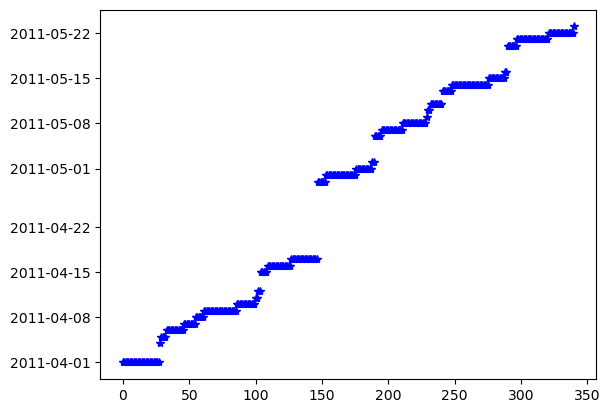

In [58]:
plt.plot(df_test["Date"], 'b*')